In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
data_dir = "C:\\Users\\91797\\Desktop\\jio\\CatDog\\DM\\Dataset"

# Updated Train Transforms
train_transforms = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),  # new
        transforms.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
        ),  # new
        transforms.RandomRotation(degrees=15),  # new
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

# Validation and Test Transforms (unchanged)
valid_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

# Datasets
train_dataset = datasets.ImageFolder(
    os.path.join(data_dir, "Train"), transform=train_transforms
)
valid_dataset = datasets.ImageFolder(
    os.path.join(data_dir, "Valid"), transform=valid_transforms
)
test_dataset = datasets.ImageFolder(
    os.path.join(data_dir, "Test"), transform=test_transforms
)

# Dataloaders
trainLoader = torch.utils.data.DataLoader(
    train_dataset, batch_size=8, shuffle=True, num_workers=4
)
validLoader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=8, shuffle=True, num_workers=4
)
testLoader = torch.utils.data.DataLoader(
    test_dataset, batch_size=8, shuffle=True, num_workers=4
)

# Combined
dataloaders = {"train": trainLoader, "val": validLoader, "test": testLoader}
dataset_sizes = {"train": len(train_dataset), "val": len(valid_dataset)}
class_names = train_dataset.classes

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
def train_model(
    model, criterion, optimizer, scheduler, num_epochs=25, patience=3, min_delta=1e-4
):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float("inf")
    epochs_no_improve = 0

    # Checkpoint filename
    checkpoint_path = "best_model.pth"

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Validation-phase logic
            if phase == "val":
                if epoch_loss < (best_loss - min_delta):
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0

                    # Save checkpoint
                    torch.save(model.state_dict(), checkpoint_path)
                    print(
                        f"✅ Checkpoint saved at Epoch {epoch} with Val Loss: {best_loss:.4f}"
                    )
                else:
                    epochs_no_improve += 1
                    print(f"No improvement in val loss for {epochs_no_improve} epochs")

                # Step scheduler (if it's ReduceLROnPlateau)
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(epoch_loss)
                elif phase == "train":
                    scheduler.step()

                # Early stopping
                if epochs_no_improve >= patience:
                    print("⛔ Early stopping triggered")
                    model.load_state_dict(
                        torch.load(checkpoint_path)
                    )  # Load best checkpoint
                    return model

    time_elapsed = time.time() - since
    print(
        f"\n✅ Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
    )
    print(f"📌 Best val Acc: {best_acc:.4f}")

    # Final load of best weights before returning
    model.load_state_dict(torch.load(checkpoint_path))
    return model

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models
from torchinfo import summary  # pip install torchinfo

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet50
# model_ft = models.resnet50(
#     weights=models.ResNet50_Weights.DEFAULT
# )  # or pretrained=True

model_ft = models.resnet18(
    weights=models.ResNet18_Weights.DEFAULT
)  # or pretrained=True

num_ftrs = model_ft.fc.in_features

# Replace the classifier head with custom head
# model_ft.fc = nn.Sequential(
#     nn.Linear(num_ftrs, 512),
#     nn.ReLU(),
#     nn.Dropout(p=0.4),
#     nn.Linear(512, 12),  # 12 classes for plant disease classification
# )

model_ft.fc = nn.Linear(num_ftrs, 12)

# Move model to device
model_ft = model_ft.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

# Print model architecture
print("🔍 Model Architecture:\n")
print(model_ft)

# Print detailed summary
print("\n📊 Model Summary:\n")
summary(model_ft, input_size=(1, 3, 224, 224))


🔍 Model Architecture:

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 12]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [5]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20
)

Epoch 0/19
----------
train Loss: 1.4236 Acc: 0.5129
val Loss: 0.8699 Acc: 0.6690
✅ Checkpoint saved at Epoch 0 with Val Loss: 0.8699
Epoch 1/19
----------
train Loss: 0.9381 Acc: 0.6714
val Loss: 0.3671 Acc: 0.8644
✅ Checkpoint saved at Epoch 1 with Val Loss: 0.3671
Epoch 2/19
----------
train Loss: 0.7608 Acc: 0.7360
val Loss: 0.4885 Acc: 0.8300
No improvement in val loss for 1 epochs
Epoch 3/19
----------
train Loss: 0.6610 Acc: 0.7731
val Loss: 0.2436 Acc: 0.9062
✅ Checkpoint saved at Epoch 3 with Val Loss: 0.2436
Epoch 4/19
----------
train Loss: 0.5770 Acc: 0.7984
val Loss: 0.2470 Acc: 0.9247
No improvement in val loss for 1 epochs
Epoch 5/19
----------
train Loss: 0.5169 Acc: 0.8204
val Loss: 0.2298 Acc: 0.9217
✅ Checkpoint saved at Epoch 5 with Val Loss: 0.2298
Epoch 6/19
----------
train Loss: 0.4959 Acc: 0.8275
val Loss: 0.2259 Acc: 0.9264
✅ Checkpoint saved at Epoch 6 with Val Loss: 0.2259
Epoch 7/19
----------
train Loss: 0.4351 Acc: 0.8519
val Loss: 0.1473 Acc: 0.9483
✅ Ch

In [6]:
torch.save(model_ft, f="./resnet18.pt")

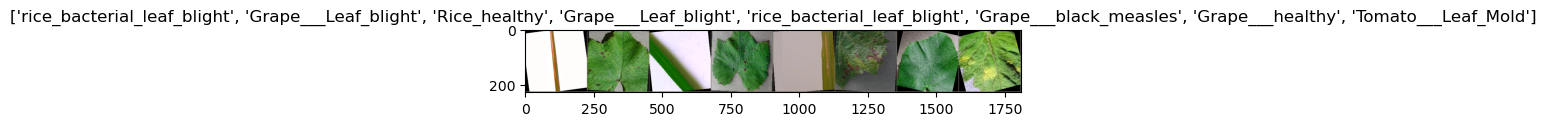

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

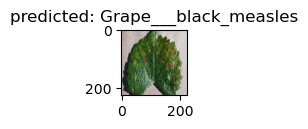

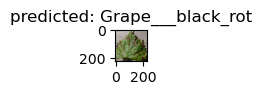

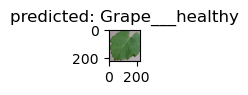

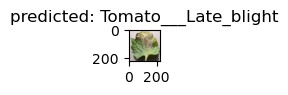

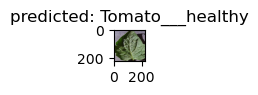

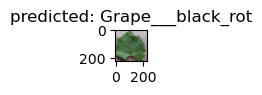

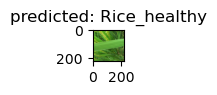

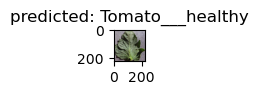

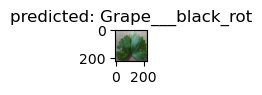

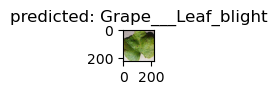

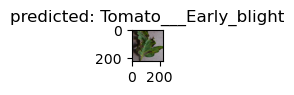

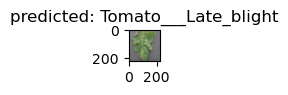

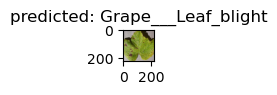

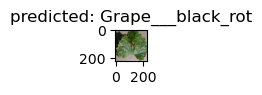

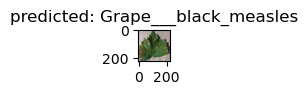

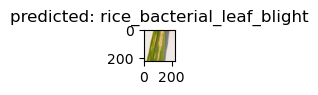

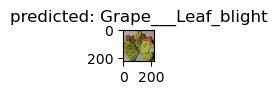

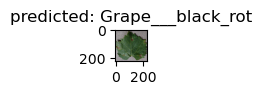

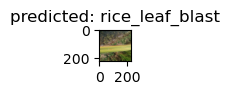

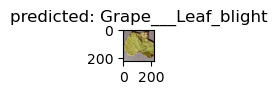

In [8]:
def visualize_model(model, num_images=20):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.set_title(f"predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


visualize_model(model_ft)


In [9]:
def test_accuracy(model_ft, testLoader):
    model_ft.eval()
    model_ft.to("cuda")

    with torch.no_grad():
        accuracy = 0
        for images, labels in iter(testLoader):
            images, labels = images.to("cuda"), labels.to("cuda")
            output = model_ft.forward(images)
            probabilities = torch.exp(output)
            equality = labels.data == probabilities.max(dim=1)[1]
            accuracy += equality.type(torch.FloatTensor).mean()
        print("test accuracy:{}".format(accuracy / len(testLoader) * 100))


test_accuracy(model_ft, testLoader)

test accuracy:96.88566589355469
